In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [27]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [29]:
duplicate_rows_data = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_rows_data.shape)

number of duplicate rows:  (3854, 9)


In [30]:
df = df.drop_duplicates()

In [31]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


In [32]:
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [33]:
df = df[df['gender'] != 'Other']

In [34]:
def recategorize_smoking(smoking_status):
    if smoking_status in ['never', 'No Info']:
        return 'non-smoker'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'


df['smoking_history'] = df['smoking_history'].apply(recategorize_smoking)


print(df['smoking_history'].value_counts())

smoking_history
non-smoker     67276
past_smoker    19655
current         9197
Name: count, dtype: int64


In [37]:
def perform_one_hot_encoding(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)
    return df


df = perform_one_hot_encoding(df, 'gender')


df = perform_one_hot_encoding(df, 'smoking_history')

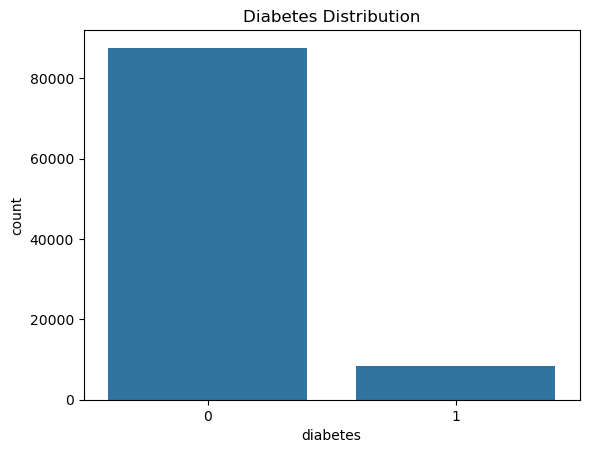

In [38]:
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [50]:
features_response = df.columns.tolist()
items_to_remove = ['gender','diabetes']
features_response = [item for item in features_response if item not
in items_to_remove]
features_response

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'HbA1c_level',
 'blood_glucose_level',
 'gender_Female',
 'gender_Male',
 'smoking_history_current',
 'smoking_history_non-smoker',
 'smoking_history_past_smoker']

In [54]:
from sklearn.model_selection import train_test_split
from sklearn import tree

X_train, X_test, y_train, y_test = \
train_test_split(df[features_response].values,
df['diabetes'].values,
test_size=0.2, random_state=24)

In [55]:
dt = tree.DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

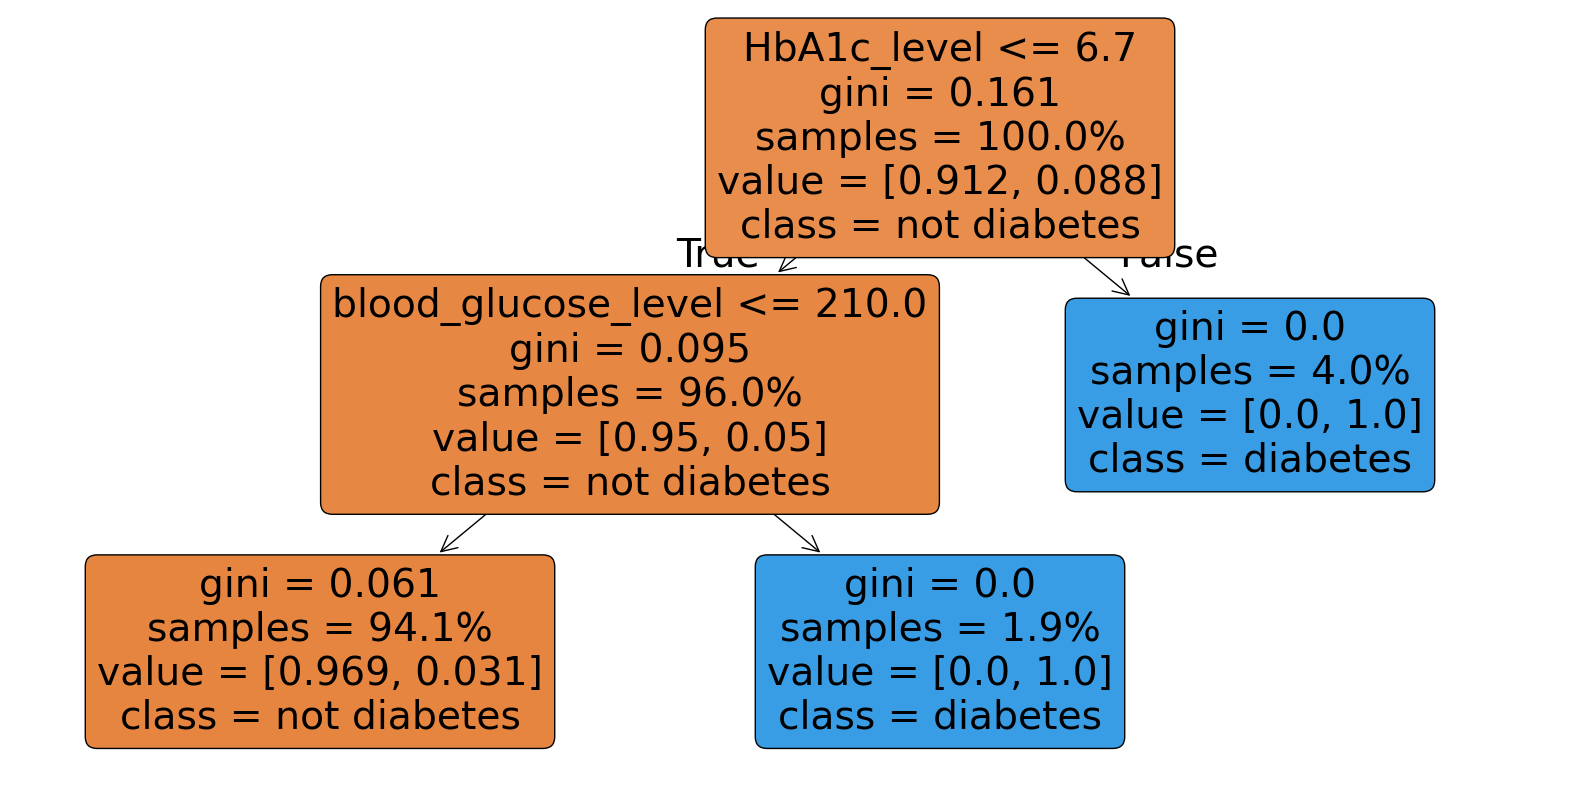

In [56]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(dt,
          feature_names=features_response[:-1],
          class_names=['not diabetes', 'diabetes'],
          filled=True,
          rounded=True,
          proportion=True)
plt.show()

In [57]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth':[1, 2, 4, 6, 8, 10, 12]} #parameters
dt = tree.DecisionTreeClassifier() #tree modal
cv = GridSearchCV(dt, param_grid=params, scoring='roc_auc',
n_jobs=None, refit=True, cv=4, verbose=1,
error_score=np.nan,
return_train_score=True) # cv is the best model.
cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             return_train_score=True, scoring='roc_auc', verbose=1)

Text(0, 0.5, 'ROC AUC')

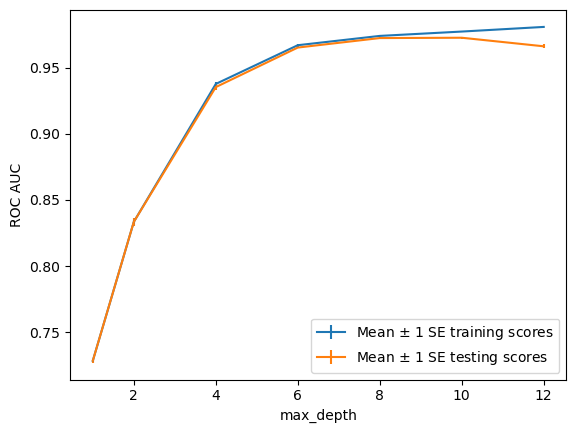

In [58]:
cv_results_df = pd.DataFrame(cv.cv_results_)
#View the names of the remaining columns in the results DataFrame
cv_results_df.columns
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
cv_results_df['mean_train_score'],
yerr=cv_results_df['std_train_score']/np.sqrt(4),
label='Mean $\pm$ 1 SE training scores')
ax.errorbar(cv_results_df['param_max_depth'],
cv_results_df['mean_test_score'],
yerr=cv_results_df['std_test_score']/np.sqrt(4),
label='Mean $\pm$ 1 SE testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier\
(n_estimators=10, criterion='gini', max_depth=3,
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0,
bootstrap=True, oob_score=False, n_jobs=None,
random_state=4, verbose=0, warm_start=False, class_weight=None)

In [60]:
rf_params_ex = {'n_estimators':list(range(10,110,10))}
cv_rf_ex = GridSearchCV(rf, param_grid=rf_params_ex,
scoring='roc_auc', n_jobs=None,
refit=True, cv=4, verbose=1,
error_score=np.nan,
return_train_score=True)

cv_rf_ex.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             return_train_score=True, scoring='roc_auc', verbose=1)

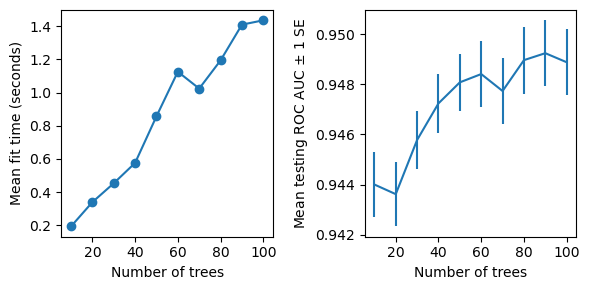

In [61]:
cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'],
cv_rf_ex_results_df['mean_fit_time'],
'-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')
axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'],
cv_rf_ex_results_df['mean_test_score'],
yerr=cv_rf_ex_results_df['std_test_score']/np.sqrt(4))
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SE ')
plt.tight_layout()

<Axes: >

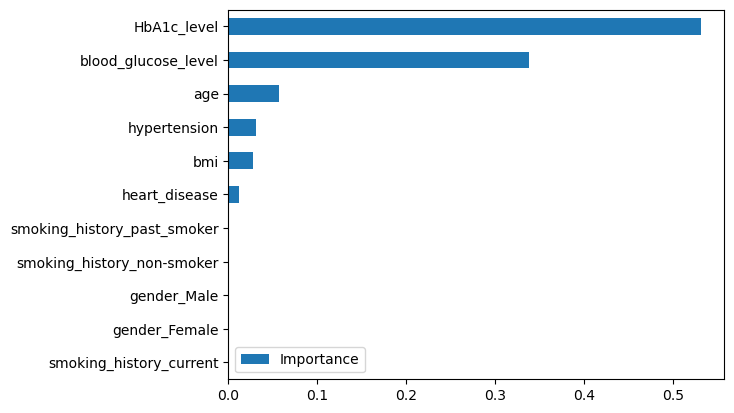

In [71]:
cv_rf_ex.best_params_
feat_imp_df = pd.DataFrame({
'Importance':cv_rf_ex.best_estimator_.feature_importances_},
index=features_response)
feat_imp_df.sort_values('Importance', ascending=True).plot.barh()